# BanDiTS - Breakpoint Detection in Sentinel-1 Time Series

## Import modules
This section is used to import all necessary modules and packages to run the example code

In [19]:
import os
import numpy as np
from skimage import exposure
from datetime import datetime
import matplotlib.pyplot as plt
from BanDiTS import preprocessing, apply_along_axis, export_arr
from BanDiTS.statistical_functions import *
from BanDiTS.filter_functions import *
from BanDiTS.breakpoint_functions import *
from pathos import multiprocessing as mp

### Define user-dependent input folders and functions to execute
The _main_ function contains all the user input to run the following functions to create the desired outputs

* _raster folder_ is used to specify the input folder location
* _raster_filname_ is used to specify the input folder location

 * This could also be enclosed in a for loop with multiple raster files to work through multiple files automaticly
 
 
* _filter_functions_ is used to specify the desired filter functions to apply
 * this can contain multiple functions in a list
* _filter_args_ contains the arguments for the filter functions (e.g.: [{"kernel": 9}])


* _statistical_functions_ is used to declare the statistical functions to execute, syntax ist equivalent to _filter_functions_
* _statistical_args_ is also equivalent to the _filter_args_ with the difference, that most statistical functions don't require arguments to run. This can be determined by looking at _statistical_functions.py_


* The _breakpoint_functions_ module can be used to access further functionionalty for breakpoint detection, it can mostly be applied in a similar fashion as the statistical functions. 


* _output_folder_ is used to specify the output folder location

In [3]:
def main():
    ###################################     INPUT    ########################################

    # Input Folder:
    raster_folder = "C:/Users/marli/Desktop/GEO402_Testdaten/Input_Files/Raster/Original/"

    # Input File Name
    raster_filename = "S1A_VH_Agulhas_50m_selected_bands_VH_2.tif"

    ###################################     OUTPUT    ########################################

    # Output Folder:
    output_folder = "C:/Users/marli/Desktop/GEO402_Testdaten/Input_Files/Raster/Original/"

    ####################### USER-DEPENDENT FILTER-FUNCTIONS TO BE USED #######################
    # Example for mean filter:
    # filter_functions = [mean_filter, mean_filter, mean_filter]
    # filter_args = [{"kernel": 3}, {"kernel": 9}, {"kernel": 13}]

    # Example for median filter:
    # filter_functions = [median_filter, median_filter, median_filter]
    # filter_args = [{"kernel": 3}, {"kernel": 9}, {"kernel": 13}]

    # Example for Sobel filter:
    filter_functions = [sobel_filter, sobel_filter, sobel_filter]
    filter_args = [{"kernel": [-5, 0, 5]}, {"kernel": [-5, -5, 0, 5, 5]}, {"kernel": [-5, -5, -5, -5, 0, 5, 5, 5, 5]}]

    ################### USER-DEPENDENT STATISTICAL FUNCTIONS TO BE USED ######################
    # Example for statistical function:
    statistical_functions = [percentile]
    statistical_args = [{"upper": 95, "lower": 5}]

    ###################### USER-DEPENDENT BREAKPOINT FUNCTIONS TO BE USED ####################
    # Example for breakpoint functions (APPLY ONLY AFTER MEDIAN- AND SOBEL-FILTER!!!):
    breakpoint_functions = [count_breakpoint]
    breakpoint_args = [{"threshold": 120}]

    ######################   NO USER INPUT BEYOND THIS POINT   ###############################

    return raster_folder, raster_filename, output_folder, filter_functions, filter_args, statistical_functions, \
        statistical_args, breakpoint_functions, breakpoint_args

## Filter function
This function is used for filtering of the time series and returns a filtered 3D stack of time series.
* It applies a for loop to iterate over the _filter_functions_ and produces an individual ouptut for each function

In [4]:
def filter_func(raster_folder, raster_filename, output_folder, filter_functions, filter_args):
    start_time = datetime.now()
    input_raster = os.path.join(raster_folder, raster_filename)
    hdr_file = ""   # only used for ENVI stacks
    outname = os.path.join(output_folder, raster_filename)
    if outname.find(".tif") != -1:
        outname = outname[0:len(outname) - 4]

    # arr: full size numpy array 3D XxYxZ 200x300x100
    arr = preprocessing.rio_array(input_raster, hdr_file=hdr_file)

    # activate to get list of dates from .hdr file (.hdr file needs to be specified above)
    # dates = arr[1]
    
    result_filt_list = []

    for i, func in enumerate(filter_functions):
        kernel_size = str(filter_args[i]['kernel'])
        filtered_arr = apply_along_axis.parallel_apply_along_axis(func1d=func, arr=arr[0], axis=0, cores=mp.cpu_count(),
                                                                  **filter_args[i])
        filtered_arr = np.rollaxis(filtered_arr, 2)
        filtered_arr = np.rollaxis(filtered_arr, 1)
        filtered_arr = np.rollaxis(filtered_arr, 2)

        dtype = type(filtered_arr[0][0][0])
        func_name_end = str(func).find(" at")
        func_name_start = 10
        func_name = str(func)[func_name_start:func_name_end]

        # exporting result to new raster
        export_arr.functions_out_array(outname=outname + "_" + func_name + str(kernel_size), arr=filtered_arr,
                                       input_file=input_raster, dtype=dtype)
        
        result_filt_list.append(result)
    return result_filt_list

    # print time to this point
    filter_time = datetime.now()
    print("filter-time = ", filter_time - start_time, "Hr:min:sec")

## Statistics function
This function is used to extract statistical parameters from the time series and returns the statistical time series values for each pixel in the x- and y-dimension of the stack.
* it applies a for loop to iterate over the _statistical_functions_ and produces an individual ouptut for each function

In [5]:
def statistics_func(raster_folder, raster_filename, output_folder, statistical_functions, statistical_args):
    start_time = datetime.now()
    input_raster = os.path.join(raster_folder, raster_filename)
    hdr_file = ""  # input_raster + ".hdr"        # only used for ENVI stacks
    outname = os.path.join(output_folder, raster_filename)
    if outname.find(".tif") != -1:
        outname = outname[0:len(outname) - 4]

    # arr: full size numpy array 3D XxYxZ 200x300x100
    arr = preprocessing.rio_array(input_raster, hdr_file=hdr_file)

    # activate to get list of dates from .hdr file (.hdr file needs to be specified above)
    # dates = arr[1]
    
    result_stat_list = []

    for i, func in enumerate(statistical_functions):
        # creating results with calling wanted algorithm in parallel_apply_along_axis for quick runtime
        result = apply_along_axis.parallel_apply_along_axis(func1d=func, arr=arr[0], axis=0,
                                                            cores=mp.cpu_count(), **statistical_args[i])

        # selecting dtype based on result
        dtype = type(result[0][0])

        func_name_end = str(func).find(" at")
        func_name_start = 10
        func_name = str(func)[func_name_start:func_name_end]

        # exporting result to new raster
        export_arr.functions_out_array(outname=outname + "_" + func_name + str(i), arr=result, input_file=input_raster,
                                       dtype=dtype)
        
        result_stat_list.append(result)
    return result_stat_list

    # print time to this point
    statistics_time = datetime.now()
    print("breakpoint-time = ", statistics_time - start_time, "Hr:min:sec")

## Breakpoint function
This function is used to execute the functions implemented in breakpoint_functions.py 
* it applies a for loop to iterate over the _breakpoint_functions_ and produces an individual ouptut for each function

In [6]:
def breakpoint_func(raster_folder, raster_filename, output_folder, breakpoint_functions, breakpoint_args):
    start_time = datetime.now()
    input_raster = os.path.join(raster_folder, raster_filename)
    hdr_file = ""   # only used for ENVI stacks
    outname = os.path.join(output_folder, raster_filename)
    if outname.find(".tif") != -1:
        outname = outname[0:len(outname) - 4]

    # arr: full size numpy array 3D XxYxZ 200x300x100
    arr = preprocessing.rio_array(input_raster, hdr_file=hdr_file)

    # activate to get list of dates from .hdr file (.hdr file needs to be specified above)
    # dates = arr[1]
    
    result_br_list = []
    
    for i, func in enumerate(breakpoint_functions):
        threshold_size = str(breakpoint_args[i]['threshold'])
        result = apply_along_axis.parallel_apply_along_axis(func1d=func, arr=arr[0], axis=0, cores=mp.cpu_count(),
                                                                  **breakpoint_args[i])
        # selecting dtype based on result
        dtype = type(result[0][0])

        func_name_end = str(func).find(" at")
        func_name_start = 10
        func_name = str(func)[func_name_start:func_name_end]

        # exporting result to new raster
        export_arr.functions_out_array(outname=outname + "_" + func_name + str(threshold_size), arr=result,
                                       input_file=input_raster, dtype=dtype)
    
        result_br_list.append(result)
    return result_br_list
    
    # print time to this point
    filter_time = datetime.now()
    print("filter-time = ", filter_time - start_time, "Hr:min:sec")

## Call main function 
This function is used to call the executable functions


In [7]:
if __name__ == '__main__':
    start_time = datetime.now()
    in_variables = main()

    # call this function to execute filter functions:
    # filter_func(raster_folder=str(in_variables[0]), raster_filename=str(in_variables[1]),
    #             output_folder=str(in_variables[2]), filter_functions=in_variables[3],
    #             filter_args=in_variables[4])

    # call this function to execute statistics functions:
    statistics_result = statistics_func(raster_folder=str(in_variables[0]), raster_filename=str(in_variables[1]),
                                        output_folder=str(in_variables[2]), statistical_functions=in_variables[5],
                                        statistical_args=in_variables[6])

    # call this function to execute breakpoint functions:
    # breakpoint_func(raster_folder=str(in_variables[0]), raster_filename=str(in_variables[1]),
    #                 output_folder=str(in_variables[2]), breakpoint_functions=in_variables[7],
    #                 breakpoint_args=in_variables[8])


## Show image
Some example visualization of the generated maps
* _For binary maps use: cmap="binary"_

<IPython.core.display.Javascript object>


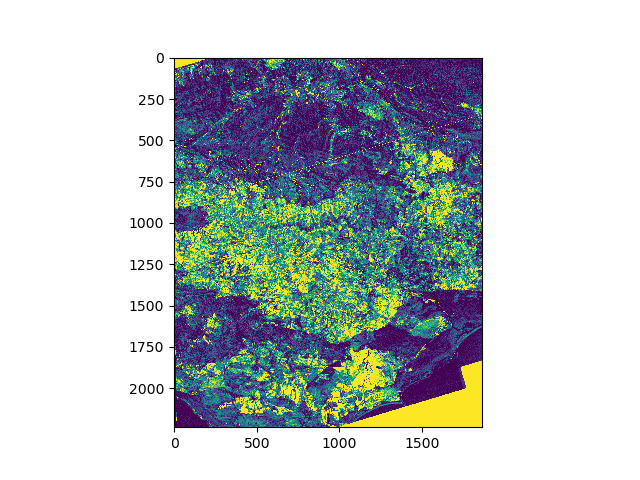

In [26]:
%matplotlib notebook
img = statistics_result[0]
p10, p90 = np.percentile(img, (10, 90))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
plt.imshow(img_rescale)